### Sandbox

In [15]:
# loading files as binary without parsing
with open("C:\\Users\\maxik\\Documents\\Semester_6\\Präsenzprüfung.pdf", "rb") as file:
    binary = file.read()
    print(binary[:20])
    print(len(binary))

print("done")

import base64
def b64_utf8_encode(string):
    string_b64 = base64.b64encode(string.encode("utf-8"))
    encodedStr = str(string_b64, "utf-8")

    print(encodedStr)
    return string_b64

def b64_utf8_decode(string):
    decodedBytes = base64.b64decode(string)
    decodedStr = str(decodedBytes, "utf-8")

    print(decodedStr)
    return decodedBytes

secret = b64_utf8_encode("It's about drive, it's about power")
print(secret)
print(b64_utf8_decode(secret))

b'%PDF-1.7\n\n4 0 obj\n<<'
1458458
done
SXQncyBhYm91dCBkcml2ZSwgaXQncyBhYm91dCBwb3dlcg==
b'SXQncyBhYm91dCBkcml2ZSwgaXQncyBhYm91dCBwb3dlcg=='
It's about drive, it's about power
b"It's about drive, it's about power"


### create default and user settings

In [20]:
import configparser
config = configparser.ConfigParser()
config['DEFAULT']['optcut']         = str(True)
config['DEFAULT']['colorspace']     = str(0)
config['DEFAULT']['max_cut']        = str(0.4)
config['DEFAULT']['max_row']        = str(900)
config['DEFAULT']['max_col']        = str(1600)
config['DEFAULT']['resize_enable']  = str(True)

with open('settings.ini', 'w') as configfile:    # save
    config.write(configfile)
    print("default settings written")


config['USER'] = {}
config['USER']['optcut']         = str(True)
config['USER']['colorspace']     = str(0)
config['USER']['max_cut']        = str(0.4)
config['USER']['max_row']        = str(900)
config['USER']['max_col']        = str(1600)
config['USER']['resize_enable']  = str(True)
with open('settings.ini', 'w') as configfile:    # save
    config.write(configfile)
print("user settings written")



config.read('settings.ini')
print(config.getboolean('DEFAULT', 'optcut'))
print(type(config.getboolean('DEFAULT', 'optcut')))

print(config.getint('DEFAULT', 'colorspace'))
print(type(config.getint('DEFAULT', 'colorspace')))

print(config.getfloat('DEFAULT', 'max_cut'))
print(type(config.getfloat('DEFAULT', 'max_cut')))

default settings written
user settings written
True
<class 'bool'>
0
<class 'int'>
0.4
<class 'float'>


<br>
<br>

# Steganography in the frequency domain via the FFT
----

### Load settings

In [80]:
colorspace_dict = { 0:"RGB", 1: "YCbCr"}

# load settings
config.read('settings.ini')
optcut          = config.getboolean('USER', 'optcut')
colorspace      = config.getint('USER', 'colorspace')
max_cut         = config.getfloat('USER', 'max_cut')
max_row         = config.getint('USER', 'max_row')
max_col         = config.getint('USER', 'max_col')
resize_enable   = config.getboolean('USER', 'resize_enable')

### Import modules and load image

image size:  (256, 256)


Text(0.5, 1.0, '2')

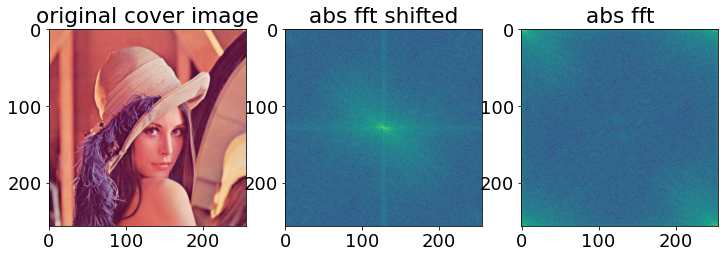

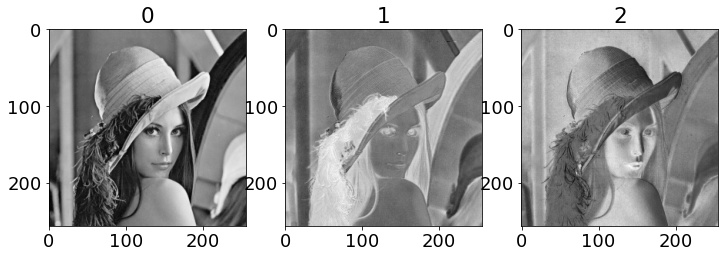

In [81]:
from PIL import Image
import numpy as np
import configparser
import matplotlib.pyplot as plt
%matplotlib inline

# some settings for inline plots
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size':18})

# specifying cover image path
cover_img_path = "ImageSources\\tif\\lena_color_256.tif"
# cover_img_path = "ImageSources\\jfif\\the_rock.jfif"
# cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jpg\\iron_patriot.jpg"
# cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jfif\\obi-wan_kenobi.jfif"


# resize image if too large (>1600/900) and return Pillow Image object (not stored yet)
def resize(cover_img_path: str) -> Image:
    image = Image.open(cover_img_path)
    # get real size
    cols, rows = image.size

    # handle exception first
    if (cols < max_col) and (rows < max_row):
        return image

    # calculate aspect ratio
    ratio = cols/rows

    # check if either dimension is greater than 1600:900
    if ratio >= max_col/max_row:
        # resize columns to max (1600) and adjust rows accordingly
        if cols > max_col:
            new_cols = max_col
            new_rows = new_cols//ratio
    else:
        # resize rows to max (900) and adjust columns accordingly
        if rows > max_row:
            new_rows = max_row
            new_cols = int(np.around(new_rows*ratio, decimals=0))

    im_resize = image.resize((int(np.around(new_cols, decimals=0)), int(np.around(new_rows, decimals=0))))
    return im_resize


if resize_enable:
    image = resize(cover_img_path)
else:
    image = Image.open(cover_img_path)

image = image.convert(colorspace_dict[colorspace])

# Rot, Grün, Blau= image.split() #split image into its RGB channels
channel0, channel1, channel2 = image.split()

print("image size: ",image.size)

plt.figure()
plt.subplot(131)
plt.imshow(image)
plt.title("original cover image")

fft_abs = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft2(channel1))))
plt.subplot(132)
plt.imshow(fft_abs)
plt.title("abs fft shifted")
fft_abs = 10*np.log10(np.abs(np.fft.fft2(channel1)))
plt.subplot(133)
plt.imshow(fft_abs)
plt.title("abs fft")
plt.figure()
plt.subplot(131)
plt.imshow(channel0, cmap="gray")
plt.title("0")
plt.subplot(132)
plt.imshow(channel1, cmap="gray")
plt.title("1")
plt.subplot(133)
plt.imshow(channel2, cmap="gray")
plt.title("2")

### Payload

In [82]:
string="""Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋"""

### Functions for encoding and decoding

In [83]:

""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text: str, gain: int) -> list:
    string_bits = text_to_bits(text)
    # convert each char to int
    message_bits = [int(i)*gain for i in string_bits]
    
    # generate HEADERS

    # get length of bitstream as bytes (overflow error if too large)
    formated = bin(len(message_bits))[2:]
    while len(formated) < 32:
        formated = '0' + formated
    message_len = [int(j)*gain for j in formated]

    header_colorspace = [colorspace * gain]

    # join header with message
    message_bits = header_colorspace + message_len + message_bits
    
    return message_bits


def text_from_bits_int(bits):
    # separate HEADER from message
    header_bits = bits[:32+1]
    
    header_colorspace = int(str(header_bits[0]), 2)

    header_message_len = ""
    # convert each element to string
    for bit in header_bits[1:]:
        header_message_len = header_message_len + str(bit)
    # convert string to int (base 2)
    header_message_len = int(header_message_len, 2)
    string_bits = [str(i) for i in bits[32+1:header_message_len+32+1]]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode, header_message_len, header_colorspace


# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img


# convert inverse transformed message to parsable binary message
def message2bin(message, threshold: int):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital

<br>
<br>
<br>

# Encoding
----

### manual gain

In [84]:
gain = 100000

### Mask

bin_encoded: [100000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cut:  0.21719110411802742
message length: 1457
confirm: 1568.0
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


C:\Users\maxik\AppData\Local\Temp/ipykernel_18092/1314372400.py:42: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(cover_fft_masked), cmap="gray")


Text(0.5, 1.0, 'Red channel in frequency domain, filtered with mask (log)')

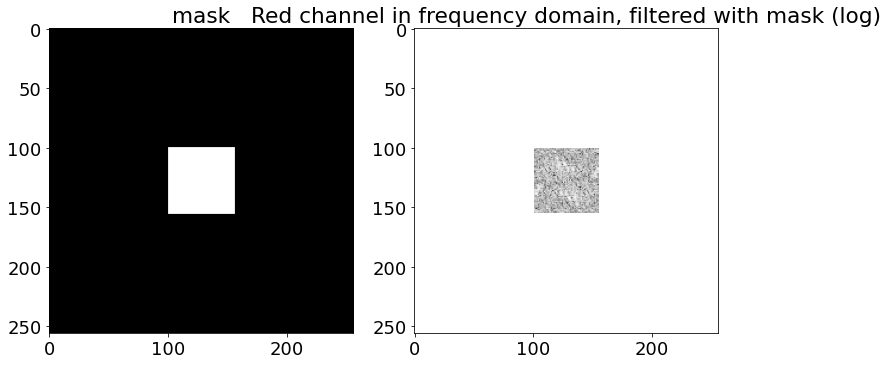

In [85]:
# apply gain to binary message
bin_encoded =  text_to_bits_int(string, gain)
print("bin_encoded:", bin_encoded[:20])

def create_FFTmask(columns, rows, message, optcut = None):
    # calculate minimum part to be cut and add another 3% because of rounding errors and for "safety"
    cut = np.sqrt(2*len(message)/(rows*columns))*1.03
    if cut > max_cut:
        raise Exception("The message is too large. Major distortions are to be expected.")
    elif not optcut:
        cut = max_cut

    #cut off high frequencies from R channel
    mask = np.full((rows, columns), False)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    mask[row_start:row_stop, col_start:col_stop] = True  # rectangular

    # x-length of the mask
    x_len_mask = col_stop - col_start 
    # y-length of the mask
    y_len_mask = row_stop - row_start 

    print("cut: ", cut)
    print("message length:", len(message))
    print("confirm:", x_len_mask*y_len_mask/2)

    return mask, cut

cover_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded, True)
# cover_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded, False)
print(cover_fft_mask[:20])

cover_fft_masked = np.abs(np.fft.fft2(channel1))*cover_fft_mask
plt.figure()
plt.subplot(121)
plt.imshow(cover_fft_mask, cmap="gray")
plt.title("mask")
plt.subplot(122)
plt.imshow(10*np.log10(cover_fft_masked), cmap="gray")
plt.title("Red channel in frequency domain, filtered with mask (log)")

### embed the message into the absolute FT

100000.0
0.0
image saved


C:\Users\maxik\AppData\Local\Temp/ipykernel_18092/4022409803.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(Image.fromarray(10*np.log10(fft_abs)))


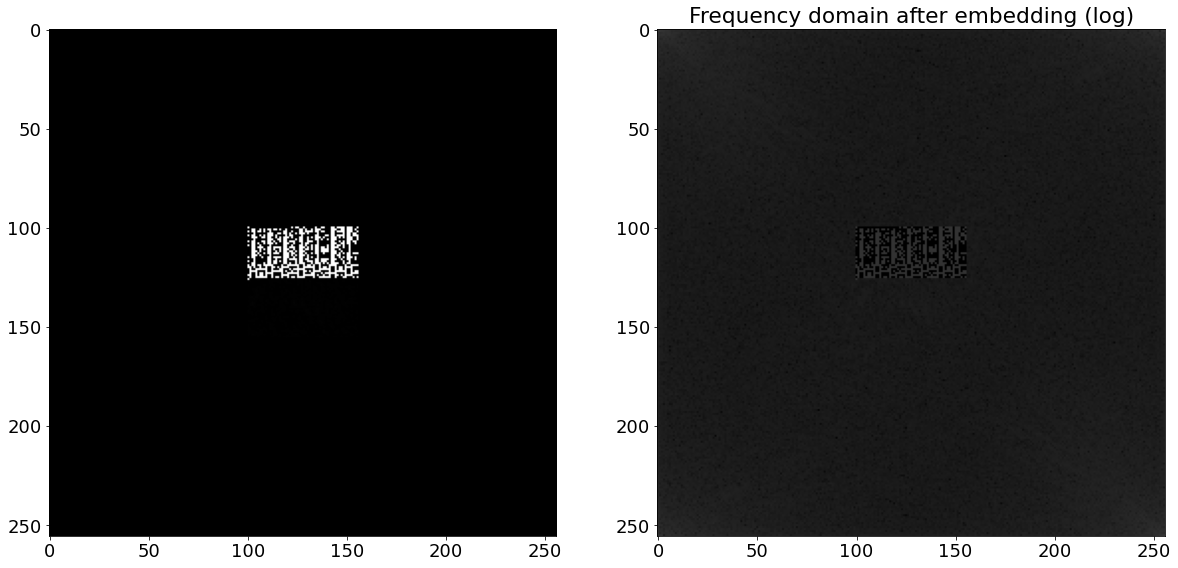

In [86]:
def embedBin2FFT(cover_channel, mask, message_digital):
    fft = np.fft.fft2(cover_channel)
    fft_abs = np.abs(fft)
    # cache message length
    message_len = len(message_digital)


    masked_fft = fft_abs[mask]

    for ii in range(message_len):
        masked_fft[ii] = message_digital[ii]
    fft_abs[mask] = masked_fft

    print(np.max(fft_abs*mask))
    print(np.min(fft_abs*mask))
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(fft_abs*mask, cmap="gray")

    # plot absolute after embedding information
    plt.subplot(122)
    plt.imshow(Image.fromarray(10*np.log10(fft_abs)))
    plt.title("Frequency domain after embedding (log)")

    #IFFT on single channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
    cover_masked = np.fft.ifft2(np.multiply(fft_abs, np.exp(np.multiply(1j, np.angle(fft))))).real
    return cover_masked

# get channel with embedded binary data
cover_masked = embedBin2FFT(channel1, cover_fft_mask, bin_encoded)

# normalize output
cover_masked_clip = np.clip(cover_masked, 0,255).astype("uint8")
# cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)

# merge layers
stego =  np.stack((channel0, cover_masked_clip, channel2), axis=2).astype('uint8')

# create steganogram and convert back to RGB again
stego_img = Image.fromarray(stego, colorspace_dict[colorspace]).convert("RGB")
# stego_img = Image.fromarray(stego)

im = stego_img.save("Steganograms\\remerged_sharp.png")     #save image as png
print("image saved")

### Plot histograms

-200.5808221739183
380.2925666845837


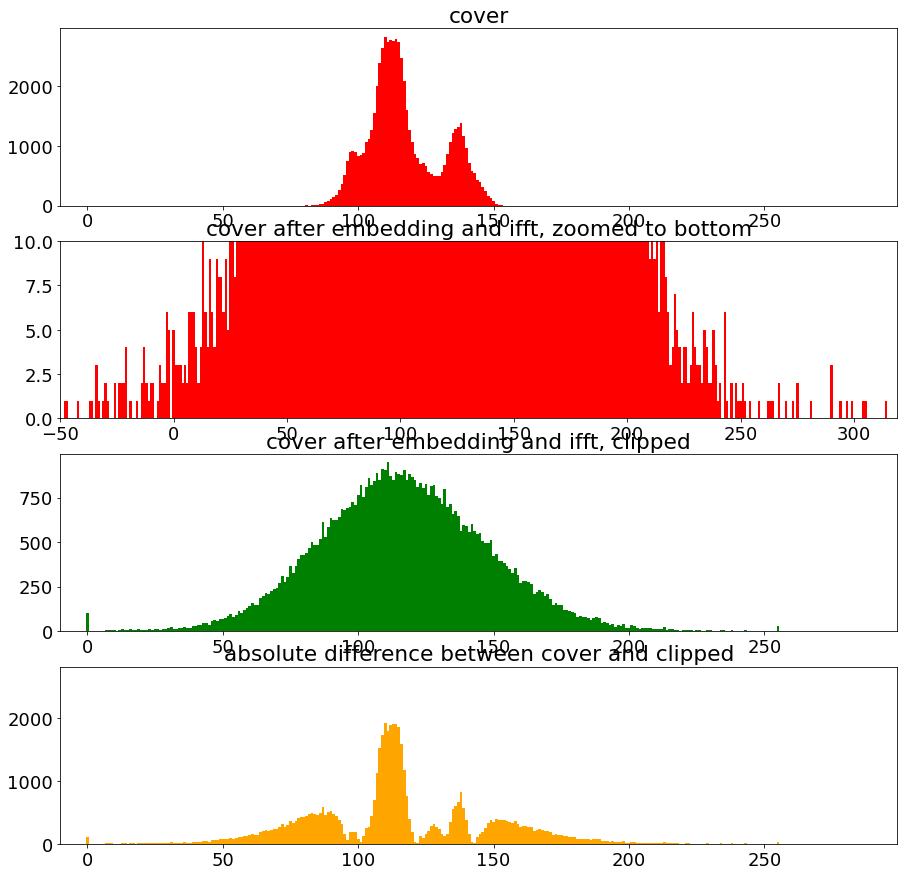

In [87]:
hist0, edges0 = np.histogram(np.array(channel1), bins=range(300))
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.bar(edges0[:-1], hist0, width = 1, color='red')
plt.xlim(-10, max(edges0))
plt.title("cover")

hist1, edges1 = np.histogram(cover_masked, bins=range(-50,320))
plt.subplot(412)
plt.bar(edges1[:-1], hist1, width = 1, color='red')
plt.xlim(min(edges1), max(edges1))
plt.ylim(0,10)
plt.title("cover after embedding and ifft, zoomed to bottom")
print(np.min(cover_masked))
print(np.max(cover_masked))

hist2, edges2 = np.histogram(cover_masked_clip, bins=range(300))
plt.subplot(413)
plt.bar(edges2[:-1], hist2, width = 1, color='green')
plt.xlim(-10, max(edges2))
plt.title("cover after embedding and ifft, clipped")

hist3 = np.abs(hist0 - hist2)
plt.subplot(414)
plt.bar(edges2[:-1], hist3, width = 1, color='orange')
plt.xlim(-10, max(edges2))
plt.ylim(0,max(hist0))
plt.title("absolute difference between cover and clipped")

plt.show()

### Some more plots

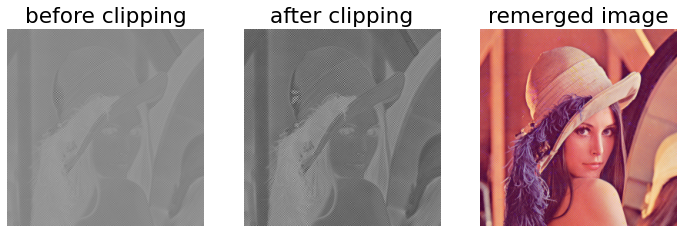

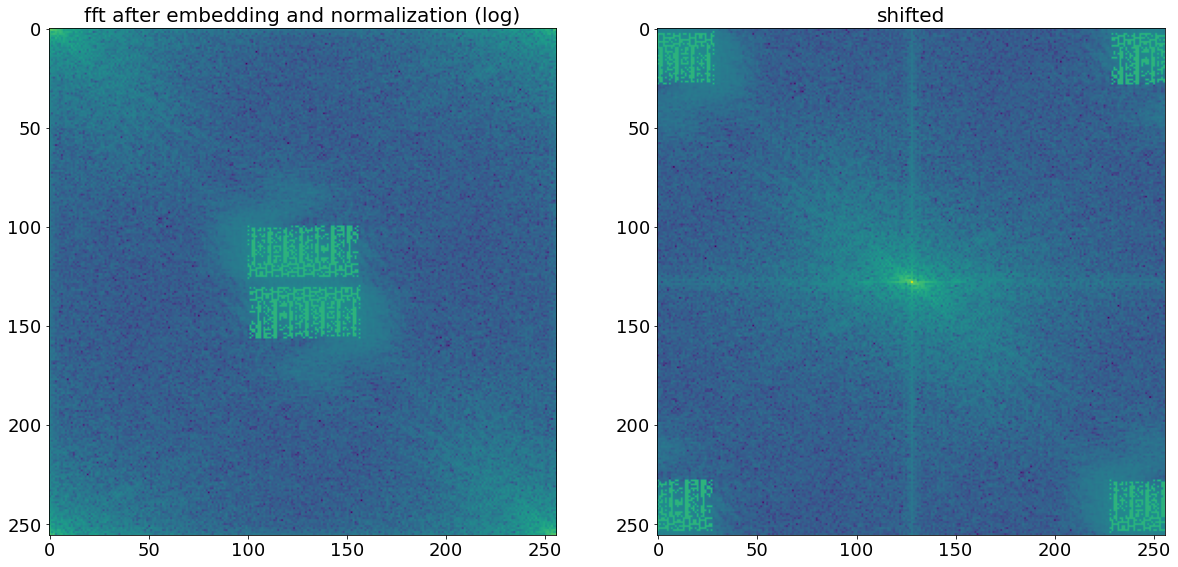

In [91]:
plt.figure()
plt.subplot(131)
plt.axis('off')
plt.imshow(cover_masked, cmap="gray")
plt.title("before clipping")
plt.subplot(132)
plt.axis('off')
plt.imshow(cover_masked_clip, cmap="gray")
plt.title("after clipping")
plt.subplot(133)
plt.axis('off')
plt.imshow(stego_img) #Show picture with embeddes secret message
plt.title("remerged image")



sanity_check = 10*np.log10(np.abs(np.fft.fft2(cover_masked_clip)))
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(sanity_check)
plt.title("fft after embedding and normalization (log)", fontsize=20)
sanity_check = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft2(cover_masked_clip))))
plt.subplot(122)
plt.imshow(sanity_check)
plt.title("shifted", fontsize=20)

plt.show()

<br>
<br>
<br>

# Decoding
----

### Calculate mask from cut variable

Text(0.5, 1.0, 'calculated fft mask')

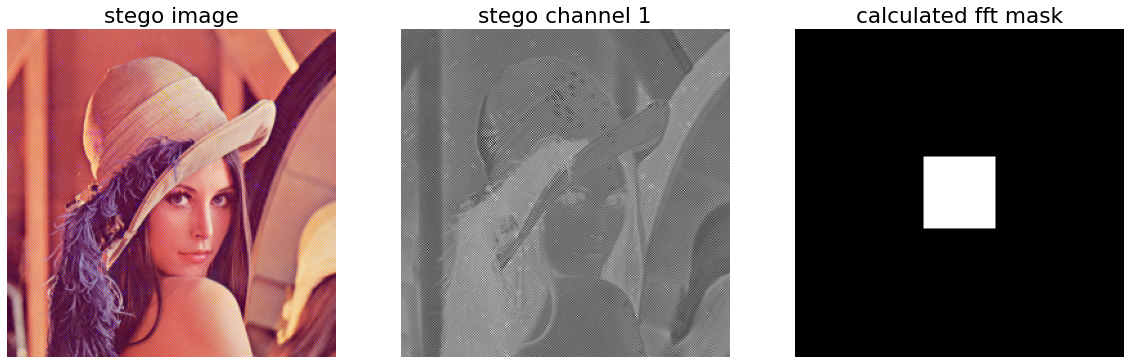

In [92]:
# load and plot image
stego_img = Image.open("Steganograms\\remerged_sharp.png").convert(colorspace_dict[colorspace])
# stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png").convert("YCbCr")

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.axis("off")
plt.imshow(stego_img.convert("RGB"))
plt.title("stego image")

steg_channel0, steg_channel1, steg_channel2 = stego_img.split() #split image into its RGB channels

plt.subplot(132)
plt.axis("off")
plt.imshow(steg_channel1, cmap="gray")
plt.title("stego channel 1")

# calculate mask
def calculate_FFTmask(columns, rows, cut = None):
    if not cut:
        cut = max_cut
    stego_fft_mask = np.full((rows, columns), False)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    stego_fft_mask[row_start:row_stop, col_start:col_stop] = True  # rectangular

    return stego_fft_mask

stego_fft_mask = calculate_FFTmask(*(stego_img.size), cut)
# stego_fft_mask = calculate_FFTmask(*(stego_img.size))

plt.subplot(133)
plt.axis("off")
plt.imshow(stego_fft_mask, cmap="gray")
plt.title("calculated fft mask")

predicted message length:  1568
[48614  2296  1976  3488  2217  2745  1145  1885  3216  2740  1237  1471
  1621  2755   578  1971  2856  3805   963   355   936  3138 47435   830
 48477 47645  4453  2620 47995   312]
threshold max/2 28670.5
binary [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0]
parsed message length 1424
parsed colorspace 1
bin_decoded:
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋
correct text:
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋


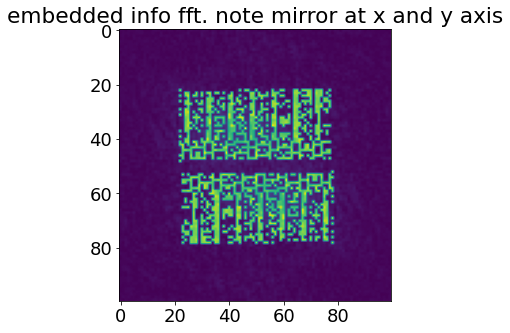

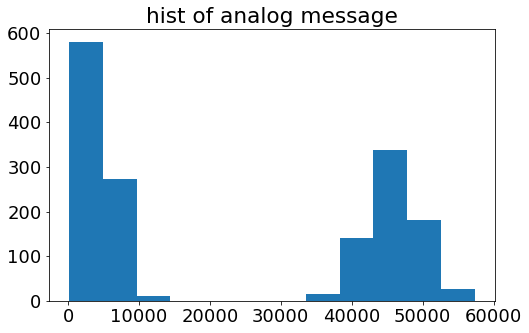

In [93]:
def get_message(stego_channel, mask):
    # transform R channel into frequency domain
    stego_fft =np.fft.fft2(stego_channel)
    stego_fft_abs = np.abs(stego_fft)

    size = stego_fft.shape
    pixel = 50
    plt.figure(figsize=(5,5))
    plt.imshow(stego_fft_abs[size[0]//2-pixel:size[0]//2+pixel, size[1]//2-pixel:size[1]//2+pixel])
    plt.title("embedded info fft. note mirror at x and y axis")
    
    # calculate message length from mask -> predicted message length > true message length!
    message_length = int(np.count_nonzero(mask == True)//2)
    print("predicted message length: ", message_length)

    # create message buffer
    message=np.zeros(message_length, dtype='uint32')

    stego_fft_masked = stego_fft_abs[mask]
    for ii in range(message_length):
        message[ii] = stego_fft_masked[ii]

    return message

# calculate threshold
def threshold_otsu(array):
    print(np.max(array))
    [hist, _] = np.histogram(array, bins=np.max(array))
    # Normalization so we have probabilities-like values (sum=1)
    hist = 1.0*hist/np.sum(hist)

    val_max = -999
    thr = -1
    for t in range(1,np.max(array)):
        # create both classes
        q1 = np.sum(hist[:t])
        q2 = np.sum(hist[t:])
        # calculate mean
        m1 = np.sum(np.array([i for i in range(t)])*hist[:t])/q1
        m2 = np.sum(np.array([i for i in range(t,np.max(array))])*hist[t:])/q2
        # calculate variance
        val = q1*(1-q1)*np.power(m1-m2,2)
        if val_max < val:
            val_max = val
            thr = t
    return thr

# copy analog values into buffer
message = get_message(steg_channel1, stego_fft_mask)

print(message[:30])

# plot histogram
hist = np.hstack(message)
plt.figure(figsize=(8,5))
plt.hist(hist, bins="auto")
plt.title("hist of analog message")

# calculate threshold the fast and easy way
threshold = np.max(message)/2
print("threshold max/2", threshold)
# threshold = threshold_otsu(message)
# print("threshold otsu", threshold)

# convert message values to binary
binary = message2bin(message, threshold)
print("binary", binary[:30])  # first 2 bytes are length of the embedded message

# convert binary to utf-8
Text, message_len_decoded, colorspace_decoded = text_from_bits_int(binary)
print("parsed message length", message_len_decoded)
print("parsed colorspace", colorspace_decoded)


print("bin_decoded:")
print(Text)
print("correct text:")
print(string)

<br>
<br>
<br>

# Automated encoding and decoding with functions from FFT_stego.py
----

Now implement a gain finder algorithm

In [1]:
from FFT_stego import *
# from FFT_stego import reset_settings

cover_img_path ="ImageSources\\tif\\lena_color_256.tif"
# cover_img_path ="ImageSources\\tif\\lena_color_512.tif"
# cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jpg\\iron_patriot.jpg"

# stego_img_path = stego_path_generator(cover_img_path, "png")
# print(stego_img_path)

# input string
string=\
"""
It's about drive, it's about power💪🧱▶🟥🎶🎧
We stay hungry, we devour
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
"""



set_settings(optcut_=True, recursive_count_=3)

load_settings()

# set_maxcut(0.4)
# cut = steg_encode_simple(cover_img_path, string, colorspace="YCbCr")
# %load_ext snakeviz
# %snakeviz cut, gain =steg_encode_simple(cover_img_path, string, optcut=True, recursive_cnt=10)
cut, gain =steg_encode_simple(cover_img_path, string)

Text = steg_decode(cut)
print("parsed text:", Text)
print("cut value:", cut)
print("gain:", gain) 

USER variable(s) set!
parsed text: 
It's about drive, it's about power💪🧱▶🟥🎶🎧
We stay hungry, we devour
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana

cut value: 0.3859145678915704
gain: 6250


Works with the following image file formats:
*   png
*   bmp
*   tiff
*   webp (not recommended)